In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rberga06.phylab import Datum as d
import math

In [2]:
# Load data
files = [pd.read_csv(f"data/TEK{i:05}.CSV", skiprows=15) for i in range(51)]
print(len(files))

51


In [3]:
def zeri(time: pd.Series, ch: pd.Series) -> list[float]:
    ch = ch - (ch.max() + ch.min())/2
    zeri: list[float] = []
    last_zero: list[float] = []
    last_i: int = -1
    for (_i, x) in time[ch.between(-1e-2,1e-2)].items():
        i2 = int(_i)
        if (i2 - last_i >= 5) and last_zero:
            # abbiamo trovato un nuovo zero
            zeri.append((last_zero[-1] + last_zero[0])/2)
            last_zero.clear()
        last_zero.append(x)
        last_i = i2
    if last_zero:
        zeri.append((last_zero[-1] + last_zero[0])/2)
    return zeri

-[2]------------------------------------------------------------------------------
4.9800796812749 Hz, 5.024620641141594 Hz
5.00225101295583 Hz
Ampiezza CH1: 2.33 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 98.71244635193132 %
Sfasamento:  0.16007203241458004 % π/2
-[3]------------------------------------------------------------------------------
1.0 Hz, 0.998402555910543 Hz
0.9992006394884093 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 99.13793103448276 %
Sfasamento:  399.5203836930456 % π/2
-[4]------------------------------------------------------------------------------
10.0 Hz, 9.984025559105431 Hz
9.992006394884093 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 99.13793103448276 %
Sfasamento:  399.5203836930456 % π/2
-[5]------------------------------------------------------------------------------
10.064412238325282 Hz, 10.032102728731942 Hz
10.04823151125402 Hz
Ampiezza CH1: 2.32 V
Ampiezza CH2: 2.3 V
Rapporto tra le ampiezze 99

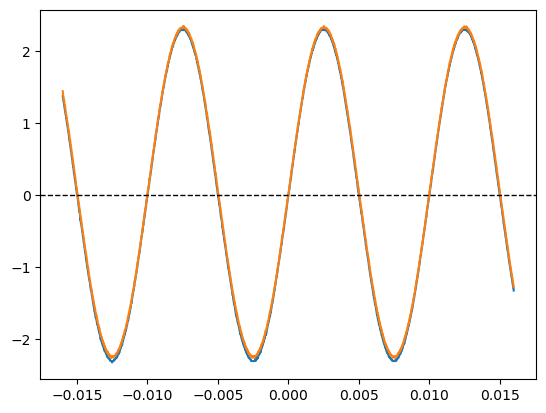

-[9]------------------------------------------------------------------------------
199.6805111821086 Hz, 200.9646302250804 Hz, 199.6805111821086 Hz, 100.16025641025641 Hz, 200.9646302250804 Hz
166.93376068376068 Hz
Ampiezza CH1: 2.3099999999999996 V
Ampiezza CH2: 2.29 V
Rapporto tra le ampiezze 99.13419913419915 %
Sfasamento:  0.5341880341880472 % π/2
-[10]------------------------------------------------------------------------------
497.6114649681529 Hz
497.6114649681529 Hz
Ampiezza CH1: 2.29 V
Ampiezza CH2: 2.27 V
Rapporto tra le ampiezze 99.12663755458514 %
Sfasamento:  3.025477707006357 % π/2
-[11]------------------------------------------------------------------------------
997.6057462090984 Hz, 1006.4412238325281 Hz
1002.0040080160321 Hz
Ampiezza CH1: 2.21 V
Ampiezza CH2: 2.18 V
Rapporto tra le ampiezze 98.64253393665159 %
Sfasamento:  4.168336673346665 % π/2
-[12]------------------------------------------------------------------------------
1996.7253703925562 Hz, 2017.4306003873

In [9]:
fasi, ampiezze1, ampiezze2, ampiezze_rapporto, frequenze = [], [], [], [], []

for (i, f) in enumerate(files):
    if i < 2: continue
    if i >= 27: break
    print(f"-[{i}]-" + "-"*77)
    time, ch1, ch2 = f["TIME"], f["CH1"], f["CH2"]

    _zeri = zeri(time, ch1)
    _diffs = [_zeri[i] - _zeri[i-1] for i in range(1, len(_zeri))]
    print(*[f"{1 / (2*x)} Hz" for x in _diffs], sep=", ")
    if len(_zeri) > 1:
        T = 2 * (sum(_diffs)/(len(_zeri)-1))
        if T != 0:
            print(_f := 1/T, "Hz")
            frequenze.append(_f)
        else:
            frequenze.append(0)
            print("{!} Errore: Il periodo è venuto pari a zero!")
    else:
        frequenze.append(0)
        print("{!} Errore: non ci sono abbastanza zeri!")
        T = 0

    print("Ampiezza CH1:", _A1 := (ch1.max() - ch1.min())/2, "V")
    print("Ampiezza CH2:", _A2 := (ch2.max() - ch2.min())/2, "V")
    print("Rapporto tra le ampiezze", (_A12 := _A2/_A1) * 100, "%")
    ampiezze1.append(_A1)
    ampiezze2.append(_A2)
    ampiezze_rapporto.append(_A12)


    dt = zeri(time, ch2)[0] - _zeri[0]
    if T != 0:
        print("Sfasamento: ", ((phi := dt / T) * 400) % 400, "% π/2")
        fasi.append(phi)
    else:
        fasi.append(0)

    if i == 8:
        fig, ax = plt.subplots()
        ax.plot(time, ch1 - (ch1.max() + ch1.min())/2)
        ax.plot(time, ch2)
        ax.axhline(0, color="0.0", linestyle="--", linewidth=1, rasterized=True)
        plt.show()

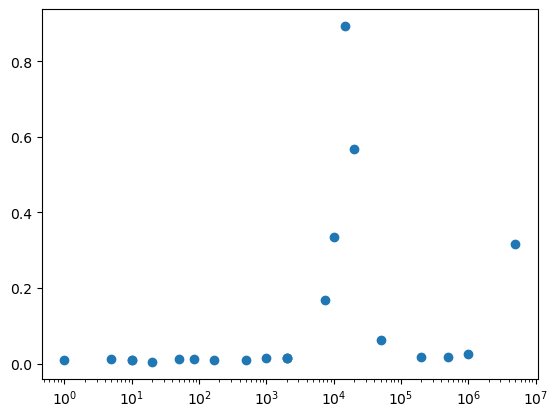

In [17]:
fig, ax = plt.subplots()
ax.scatter(frequenze, [1 - x for x in ampiezze_rapporto])
ax.set_xscale('log')
plt.show()

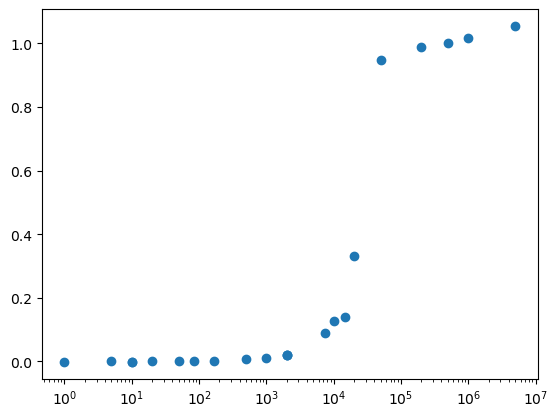

In [19]:
fasi = [phi + int(nu >= 4e4) for (nu, phi) in zip(frequenze, fasi)]
fig, ax = plt.subplots()
ax.scatter(frequenze, fasi)
ax.set_xscale('log')
plt.show()